In [1]:
!pip install tf-nightly-2.0-preview


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

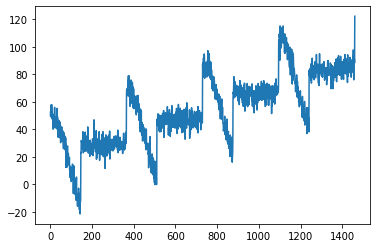

In [5]:
plt.plot(series)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))



<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.1108072 ],
       [ 0.04849157],
       [ 0.06259218],
       [-0.01455177],
       [ 0.02113022],
       [-0.00998581],
       [-0.01189139],
       [ 0.04726803],
       [-0.04845456],
       [ 0.08095632],
       [-0.11448605],
       [-0.02395753],
       [ 0.0277235 ],
       [ 0.09168153],
       [-0.02489213],
       [ 0.06239042],
       [ 0.00872023],
       [ 0.16797318],
       [ 0.2175663 ],
       [ 0.50279695]], dtype=float32), array([0.01484227], dtype=float32)]


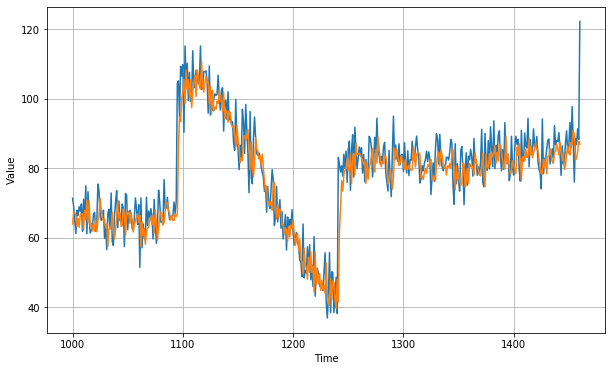

In [9]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.2021613

In [12]:
for time in range(len(series) - window_size)[:5]:
  print(series[time:time + window_size])

[52.48357  49.35275  53.314735 57.711823 48.934444 48.931244 57.982895
 53.897125 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178
 40.919415 46.612473 44.228207 50.720642 44.454983 41.76799 ]
[49.35275  53.314735 57.711823 48.934444 48.931244 57.982895 53.897125
 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178 40.919415
 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938]
[53.314735 57.711823 48.934444 48.931244 57.982895 53.897125 47.67393
 52.68371  47.591717 47.506374 50.959415 40.086178 40.919415 46.612473
 44.228207 50.720642 44.454983 41.76799  55.980938 47.335835]
[57.711823 48.934444 48.931244 57.982895 53.897125 47.67393  52.68371
 47.591717 47.506374 50.959415 40.086178 40.919415 46.612473 44.228207
 50.720642 44.454983 41.76799  55.980938 47.335835 48.6033  ]
[48.934444 48.931244 57.982895 53.897125 47.67393  52.68371  47.591717
 47.506374 50.959415 40.086178 40.919415 46.612473 44.228207 50.720642
 44.454983 41.76799  55.980938 47.335835 48.

In [13]:
window_size

20

In [14]:
split_time

1000

In [0]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]

In [17]:
forecast

[array([[63.92708]], dtype=float32),
 array([[67.30282]], dtype=float32),
 array([[67.1954]], dtype=float32),
 array([[66.60345]], dtype=float32),
 array([[63.19257]], dtype=float32),
 array([[65.53152]], dtype=float32),
 array([[62.969463]], dtype=float32),
 array([[66.5825]], dtype=float32),
 array([[66.95175]], dtype=float32),
 array([[66.706154]], dtype=float32),
 array([[62.10678]], dtype=float32),
 array([[67.863045]], dtype=float32),
 array([[65.22517]], dtype=float32),
 array([[70.89217]], dtype=float32),
 array([[64.47697]], dtype=float32),
 array([[70.605576]], dtype=float32),
 array([[63.30145]], dtype=float32),
 array([[64.156006]], dtype=float32),
 array([[61.89273]], dtype=float32),
 array([[63.922348]], dtype=float32),
 array([[61.911106]], dtype=float32),
 array([[65.12808]], dtype=float32),
 array([[61.69159]], dtype=float32),
 array([[64.835175]], dtype=float32),
 array([[66.480675]], dtype=float32),
 array([[71.32777]], dtype=float32),
 array([[68.15058]], dtype=floa

In [18]:
np.array(forecast)[:, 0, 0]

array([ 63.92708 ,  67.30282 ,  67.1954  ,  66.60345 ,  63.19257 ,
        65.53152 ,  62.969463,  66.5825  ,  66.95175 ,  66.706154,
        62.10678 ,  67.863045,  65.22517 ,  70.89217 ,  64.47697 ,
        70.605576,  63.30145 ,  64.156006,  61.89273 ,  63.922348,
        61.911106,  65.12808 ,  61.69159 ,  64.835175,  66.480675,
        71.32777 ,  68.15058 ,  66.02003 ,  64.79656 ,  65.3626  ,
        62.827175,  63.921555,  57.48775 ,  62.512615,  62.522694,
        63.377678,  67.272194,  62.34847 ,  59.596676,  62.198402,
        65.69375 ,  70.7185  ,  65.62574 ,  67.07161 ,  63.277775,
        63.395195,  68.26047 ,  67.11845 ,  60.68424 ,  66.30964 ,
        67.1457  ,  67.38548 ,  64.10157 ,  67.29221 ,  65.12989 ,
        61.636707,  63.87179 ,  64.71505 ,  65.93783 ,  66.94529 ,
        64.3514  ,  66.404854,  57.416004,  64.50891 ,  60.533596,
        62.64098 ,  58.094765,  61.681038,  62.6396  ,  63.082096,
        65.39727 ,  65.78925 ,  63.74163 ,  66.354774,  61.266

In [19]:
len(np.array(forecast)[:, 0, 0])

461

In [21]:
len(x_valid)

461